# Project 1: Investigate a Dataset — European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

The database was sourced from [**Kaggle**](https://www.kaggle.com/datasets/hugomathien/soccer), a popular platform for users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

The European soccer database (which can be downloaded [**here**](https://d17h27t6h515a5.cloudfront.net/topher/2017/November/5a0a4cad_database/database.sqlite)) is stored in a SQLite database and contains the following structure (Schema):

**Table**|**Total Rows**|**Total Columns**
----|--------|--------
Country|11|2
League|11|3
Match|	25979	|115
Player|	11060|	7
Player_Attributes|	183978	|42
Team|	299	|5
Team_Attributes|	1458|	25

The following further explains what is contained within the tables of the database.
* over 25,000 matches and 10,000 players with their attributes from the popular EA Sports' FIFA video game
* 11 leagues across Europe span eight (8) seasons from 2008 to 2016
* Teams and Teams' attributes also included
* Betting odds from up to 10 providers including Bet365 (B365), BetWay (BW), etc.
* Other details also included in the database.


### Question(s) for Analysis
In an attempt to draw out some conclusions from the dataset, some explorations will be done for better understanding. For this course, the questions below will be explored.

1. Which teams scored the most goals each of the two seasons?
2. Which teams were relegated (to lower division) at the end of the 2014/2015 seasons?
3. Which teams got promoted (from lower division) into the 2015/2016 season?
4. What is the final standing/position of each team at the end of the 14/15 season?
5. Which attributes are most likely responsible for the home matches won?


### Imported Modules

In [1]:
# Libraries and modules in alphabetical order
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

In [52]:
# Upgrade pandas to use dataframe.explode() function. 
# !pip install --upgrade pandas==0.25.0

<a id='wrangling'></a>
## Data Wrangling

In this section of the report, the dataframe will be loaded into a variable `df`. More check checks and cleaning will also be done to fully understand the data. Certain column(s) and row(s) will be dropped if found irrelevant in our analysis. the dataframe will all be sub-divided into other dataframes if necessary.

### A `frame()` Function
The "frame" function below takes in the path where the sqlite database is located as an argument, connects to the DB, queries it using SQL, and then returns a dataframe to be further cleaned and wrangled.

> The SQL query in the function was used in joining the "League", "Match", "Team", and "Team_Attributes" tables together. The query has also done a bit of cleaning by selecting only a number of useful columns. Further cleaning and exploration will be done afterwards. 

Some key abbreviations to note are:
* ht, htm >> Home Team
* at, atm >> Away Team
* ht/at_bup >> Home/Away team build_up_play
* ht/at_cc >> Home/Away team chance creation
* ht/at_df >> Home/Away team defence
* b365h >> Bet365 odd Odd for **Home win**
* b356d >> Bet365 odd for **a draw**
* b365a >> Bet365 odd for **Away win**

Other details or column names are very much self explanatory 

Two matches from two (2) full English Premier Leagues (EPL) seasons (2014/2015, 2015/2016 seasons) are extracted from the database where each season begins in August of one year and ends in may of the following year, i.e:
* 1st season >> August 2014 (2014-08) to May 2015 (2015-05)
* 2nd season >> August 2015 (2015-08) to May 2016 (2016-05)
It is also important to note that the English premier league feature a fixed number of teams *(20 teams)* and games *(380 games, divided into 38 **stages*** with an average of 10 games per stage from all 20 teams paired up)* each season.

In [2]:
def frame(db_path):
    # Connect Database
    conn = sqlite3.connect(db_path)
    
    # Construct query
    query = '''
        WITH home_team as (
            SELECT  match_api_id, team_api_id, team_long_name, team_short_name	
            FROM  "Match" 
            JOIN Team ON Match.home_team_api_id  = team.team_api_id
            ),
            away_team as (
            SELECT  match_api_id, team_api_id, team_long_name, team_short_name	
            FROM  "Match" 
            JOIN Team ON Match.away_team_api_id  = team.team_api_id
            ),

            htm_attribute as(
            SELECT match_api_id, team_api_id, ta.date as hdate,
                buildUpPlaySpeed as ht_bup_speed, buildUpPlayDribbling as ht_bup_dribbling, buildUpPlayPassing as ht_bup_passing,
                chanceCreationPassing as ht_cc_passing, chanceCreationCrossing as ht_cc_crossing, chanceCreationShooting as ht_cc_shooting, 
                defencePressure as ht_df_pressure, defenceAggression as ht_df_aggression, defenceTeamWidth as ht_df_teamwidth
            FROM   Team_Attributes as ta
            JOIN "Match" ON Match.home_team_api_id  = ta.team_api_id
            WHERE ta.date LIKE "%2015%"
            ),
            atm_attribute as(
            SELECT match_api_id, team_api_id, ta.date as adate,
                buildUpPlaySpeed as at_bup_speed, buildUpPlayDribbling as at_bup_dribbling, buildUpPlayPassing as at_bup_passing,
                chanceCreationPassing as at_cc_passing, chanceCreationCrossing as at_cc_crossing, chanceCreationShooting as at_cc_shooting, 
                defencePressure as at_df_pressure, defenceAggression as at_df_aggression, defenceTeamWidth as at_df_teamwidth
            FROM   Team_Attributes as ta
            JOIN "Match" ON Match.away_team_api_id = ta.team_api_id
            WHERE ta.date LIKE "%2015%"
            )

            SELECT  
                "date", stage
                ,home_team_api_id, away_team_api_id
                ,htm.team_long_name as home_teams, home_team_goal
                ,away_team_goal, atm.team_long_name as away_teams,
                B365H as b365h, B365D as b356d, B365A as b365a, 
                ht_bup_speed, at_bup_speed,  ht_bup_dribbling, at_bup_dribbling, ht_bup_passing, at_bup_passing,
                 ht_cc_passing, at_cc_passing, ht_cc_crossing, at_cc_crossing, ht_cc_shooting, at_cc_shooting, 
                 ht_df_pressure, at_df_pressure, ht_df_aggression,  at_df_aggression, ht_df_teamwidth, at_df_teamwidth



            FROM  "Match" 
            JOIN home_team as htm  ON Match.match_api_id  = htm.match_api_id  
            JOIN away_team as atm ON  Match.match_api_id  = atm.match_api_id
            JOIN htm_attribute  as htma ON  match.match_api_id  = htma.match_api_id 
            JOIN atm_attribute  as atma ON  match.match_api_id  = atma.match_api_id 


            WHERE  
                league_id = 1729 --filter out the English Premier League
                AND (season LIKE "%2015/2016%" OR season LIKE "%2014/2015%")
            ORDER BY stage
        '''
    # Read query results into DataFrame
    df = pd.read_sql(query, conn)
    
    # Convert date column to datetime format
    df["date"] = pd.to_datetime(df["date"] )
    
    # Set index  
    df = df.set_index("date")
    
    return df
    


> In a case where the `.sqlite` database is not accessible, the function above can be easily modified to take a csv file instead (the resulting csv file from the SQL query is present in repository). In this case, the dataframe in function changes from `df = pd.read_sql(query, conn)` to `df = pd.read_csv(db_path)` where `dp_path` is the path to the csv file.

In [4]:
# Loading data...
df = frame("../database.sqlite")

In [5]:
df.head()

,stage,home_team_api_id,away_team_api_id,home_teams,home_team_goal,away_team_goal,away_teams,b365h,b356d,b365a,...,ht_cc_crossing,at_cc_crossing,ht_cc_shooting,at_cc_shooting,ht_df_pressure,at_df_pressure,ht_df_aggression,at_df_aggression,ht_df_teamwidth,at_df_teamwidth
date,,,,,,,,,,,,,,,,,,,,,
2014-08-16,1,9825,9826,Arsenal,2,1,Crystal Palace,1.25,6.50,15.0,...,44,69,46,50,51,36,44,34,52,41
2014-08-18,1,8191,8455,Burnley,1,3,Chelsea,9.00,5.00,1.4,...,57,34,47,44,63,39,62,41,58,46
2014-08-16,1,8197,8668,Leicester City,2,2,Everton,3.20,3.40,2.4,...,64,33,46,63,58,52,65,58,55,59
2014-08-17,1,8650,8466,Liverpool,2,1,Southampton,1.33,5.75,10.0,...,34,54,46,30,51,50,52,65,61,44
2014-08-16,1,10260,10003,Manchester United,1,2,Swansea City,1.36,5.00,11.0,...,44,36,40,55,54,31,53,47,56,42


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 760 entries, 2014-08-16 to 2016-05-15
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stage             760 non-null    int64  
 1   home_team_api_id  760 non-null    int64  
 2   away_team_api_id  760 non-null    int64  
 3   home_teams        760 non-null    object 
 4   home_team_goal    760 non-null    int64  
 5   away_team_goal    760 non-null    int64  
 6   away_teams        760 non-null    object 
 7   b365h             760 non-null    float64
 8   b356d             760 non-null    float64
 9   b365a             760 non-null    float64
 10  ht_bup_speed      760 non-null    int64  
 11  at_bup_speed      760 non-null    int64  
 12  ht_bup_dribbling  760 non-null    int64  
 13  at_bup_dribbling  760 non-null    int64  
 14  ht_bup_passing    760 non-null    int64  
 15  at_bup_passing    760 non-null    int64  
 16  ht_cc_passing     760 non

The result from of the `.info()` method shows that we do not have any missing/null value in our data. This will be confirmed below. The result also shows that each table has the expected and proper data types (dtypes).
By domain knowledge, I can also conclude that the data has no duplicate rows based on the number of rows in the entire dataframe.

In [7]:
# Number of null values per column
(df.isnull().sum())

stage               0
home_team_api_id    0
away_team_api_id    0
home_teams          0
home_team_goal      0
away_team_goal      0
away_teams          0
b365h               0
b356d               0
b365a               0
ht_bup_speed        0
at_bup_speed        0
ht_bup_dribbling    0
at_bup_dribbling    0
ht_bup_passing      0
at_bup_passing      0
ht_cc_passing       0
at_cc_passing       0
ht_cc_crossing      0
at_cc_crossing      0
ht_cc_shooting      0
at_cc_shooting      0
ht_df_pressure      0
at_df_pressure      0
ht_df_aggression    0
at_df_aggression    0
ht_df_teamwidth     0
at_df_teamwidth     0
dtype: int64

In [8]:
df.describe()

,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,b365h,b356d,b365a,ht_bup_speed,at_bup_speed,...,ht_cc_crossing,at_cc_crossing,ht_cc_shooting,at_cc_shooting,ht_df_pressure,at_df_pressure,ht_df_aggression,at_df_aggression,ht_df_teamwidth,at_df_teamwidth
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,...,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,19.500000,9178.575000,9178.575000,1.482895,1.150000,2.672066,3.965066,4.597855,54.875000,54.875000,...,48.650000,48.650000,46.750000,46.750000,45.425000,45.425000,47.200000,47.200000,50.950000,50.950000
std,10.973078,780.261243,780.261243,1.260413,1.109843,1.437462,0.917408,3.254712,10.531159,10.531159,...,11.397299,11.397299,10.572823,10.572823,9.096882,9.096882,9.045311,9.045311,6.053571,6.053571
min,1.000000,8191.000000,8191.000000,0.000000,0.000000,1.170000,3.100000,1.360000,30.000000,30.000000,...,33.000000,33.000000,24.000000,24.000000,30.000000,30.000000,34.000000,34.000000,41.000000,41.000000
25%,10.000000,8472.000000,8472.000000,1.000000,0.000000,1.730000,3.400000,2.500000,46.500000,46.500000,...,39.750000,39.750000,43.000000,43.000000,38.000000,38.000000,39.750000,39.750000,46.000000,46.000000
50%,19.500000,8667.500000,8667.500000,1.000000,1.000000,2.250000,3.600000,3.500000,58.000000,58.000000,...,48.500000,48.500000,46.000000,46.000000,47.000000,47.000000,45.000000,45.000000,51.000000,51.000000
75%,29.000000,10003.000000,10003.000000,2.000000,2.000000,3.025000,4.200000,5.250000,62.250000,62.250000,...,54.000000,54.000000,55.000000,55.000000,51.000000,51.000000,53.000000,53.000000,55.250000,55.250000
max,38.000000,10261.000000,10261.000000,8.000000,6.000000,10.000000,9.000000,21.000000,77.000000,77.000000,...,73.000000,73.000000,63.000000,63.000000,63.000000,63.000000,65.000000,65.000000,62.000000,62.000000


The `.describe()` method above already gave us a quick insight into our data.

The obvious here is when we look at the average Bet365 odds for home or away wins over the entire 2 seasons, we see that the home team is more likely to win a match on average.


### Data Cleaning
Most of the cleaning have been done in the the using the SQL query. What is left is to drop the `home_team_api_id` and `away_team_api_id` columns. It is also important to divide the two different season into 2 different DataFrames


> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [9]:
df = df.drop(columns = ["home_team_api_id", "away_team_api_id"])
df.head()

,stage,home_teams,home_team_goal,away_team_goal,away_teams,b365h,b356d,b365a,ht_bup_speed,at_bup_speed,...,ht_cc_crossing,at_cc_crossing,ht_cc_shooting,at_cc_shooting,ht_df_pressure,at_df_pressure,ht_df_aggression,at_df_aggression,ht_df_teamwidth,at_df_teamwidth
date,,,,,,,,,,,,,,,,,,,,,
2014-08-16,1,Arsenal,2,1,Crystal Palace,1.25,6.50,15.0,59,61,...,44,69,46,50,51,36,44,34,52,41
2014-08-18,1,Burnley,1,3,Chelsea,9.00,5.00,1.4,54,67,...,57,34,47,44,63,39,62,41,58,46
2014-08-16,1,Leicester City,2,2,Everton,3.20,3.40,2.4,63,43,...,64,33,46,63,58,52,65,58,55,59
2014-08-17,1,Liverpool,2,1,Southampton,1.33,5.75,10.0,66,52,...,34,54,46,30,51,50,52,65,61,44
2014-08-16,1,Manchester United,1,2,Swansea City,1.36,5.00,11.0,38,45,...,44,36,40,55,54,31,53,47,56,42


In [10]:
df_14_15 = df["2014-08":"2015-05"]
df_14_15.head()
df_14_15.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 380 entries, 2014-08-16 to 2015-05-24
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stage             380 non-null    int64  
 1   home_teams        380 non-null    object 
 2   home_team_goal    380 non-null    int64  
 3   away_team_goal    380 non-null    int64  
 4   away_teams        380 non-null    object 
 5   b365h             380 non-null    float64
 6   b356d             380 non-null    float64
 7   b365a             380 non-null    float64
 8   ht_bup_speed      380 non-null    int64  
 9   at_bup_speed      380 non-null    int64  
 10  ht_bup_dribbling  380 non-null    int64  
 11  at_bup_dribbling  380 non-null    int64  
 12  ht_bup_passing    380 non-null    int64  
 13  at_bup_passing    380 non-null    int64  
 14  ht_cc_passing     380 non-null    int64  
 15  at_cc_passing     380 non-null    int64  
 16  ht_cc_crossing    380 non

C:\Users\damol\AppData\Local\Temp/ipykernel_10084/990133925.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_14_15 = df["2014-08":"2015-05"]


In [11]:
df_15_16 = df["2015-08":"2016-05"]
df_15_16.head()
df_15_16.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 380 entries, 2015-08-09 to 2016-05-15
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stage             380 non-null    int64  
 1   home_teams        380 non-null    object 
 2   home_team_goal    380 non-null    int64  
 3   away_team_goal    380 non-null    int64  
 4   away_teams        380 non-null    object 
 5   b365h             380 non-null    float64
 6   b356d             380 non-null    float64
 7   b365a             380 non-null    float64
 8   ht_bup_speed      380 non-null    int64  
 9   at_bup_speed      380 non-null    int64  
 10  ht_bup_dribbling  380 non-null    int64  
 11  at_bup_dribbling  380 non-null    int64  
 12  ht_bup_passing    380 non-null    int64  
 13  at_bup_passing    380 non-null    int64  
 14  ht_cc_passing     380 non-null    int64  
 15  at_cc_passing     380 non-null    int64  
 16  ht_cc_crossing    380 non

C:\Users\damol\AppData\Local\Temp/ipykernel_10084/1903638683.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_15_16 = df["2015-08":"2016-05"]


In [12]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.


<a id='eda'></a>
## Exploratory Data Analysis

In [13]:
df.columns

Index(['stage', 'home_teams', 'home_team_goal', 'away_team_goal', 'away_teams',
       'b365h', 'b356d', 'b365a', 'ht_bup_speed', 'at_bup_speed',
       'ht_bup_dribbling', 'at_bup_dribbling', 'ht_bup_passing',
       'at_bup_passing', 'ht_cc_passing', 'at_cc_passing', 'ht_cc_crossing',
       'at_cc_crossing', 'ht_cc_shooting', 'at_cc_shooting', 'ht_df_pressure',
       'at_df_pressure', 'ht_df_aggression', 'at_df_aggression',
       'ht_df_teamwidth', 'at_df_teamwidth'],
      dtype='object')

In [14]:
# Checking the number of unique stages
print(df["stage"].unique())
df["stage"].nunique()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


38

### Q1: Which teams scored the most goals each of the two seasons?


In [15]:
# number of games played at home by each team in the 04/05 season
df_14_15.groupby("home_teams")["home_teams"].count()

home_teams
Arsenal                 19
Aston Villa             19
Burnley                 19
Chelsea                 19
Crystal Palace          19
Everton                 19
Hull City               19
Leicester City          19
Liverpool               19
Manchester City         19
Manchester United       19
Newcastle United        19
Queens Park Rangers     19
Southampton             19
Stoke City              19
Sunderland              19
Swansea City            19
Tottenham Hotspur       19
West Bromwich Albion    19
West Ham United         19
Name: home_teams, dtype: int64

In [16]:
# number of games played away by each team in the 05/06 season
df_15_16.groupby("home_teams")["home_teams"].count()

home_teams
Arsenal                 19
Aston Villa             19
Bournemouth             19
Chelsea                 19
Crystal Palace          19
Everton                 19
Leicester City          19
Liverpool               19
Manchester City         19
Manchester United       19
Newcastle United        19
Norwich City            19
Southampton             19
Stoke City              19
Sunderland              19
Swansea City            19
Tottenham Hotspur       19
Watford                 19
West Bromwich Albion    19
West Ham United         19
Name: home_teams, dtype: int64

In [17]:
# number of games played by each team in both season
df.groupby("home_teams")["home_teams"].count()

home_teams
Arsenal                 38
Aston Villa             38
Bournemouth             19
Burnley                 19
Chelsea                 38
Crystal Palace          38
Everton                 38
Hull City               19
Leicester City          38
Liverpool               38
Manchester City         38
Manchester United       38
Newcastle United        38
Norwich City            19
Queens Park Rangers     19
Southampton             38
Stoke City              38
Sunderland              38
Swansea City            38
Tottenham Hotspur       38
Watford                 19
West Bromwich Albion    38
West Ham United         38
Name: home_teams, dtype: int64

**Note:** From the above, the teams with the 19 out of 38 games played either relegated from the  EPL at the end of the 1st season (14/15) or got promoted into the EPL at the begining of the 2nd season (15/16)

Below: Analyzing the **14/15** season goals and betting odds for the home and the away teams

In [18]:
# Total number of goals scored by home team in first season and the average odds for winning as the home match
home_14_15 = df_14_15.groupby("home_teams").agg({"home_team_goal": np.sum, "b365h":np.mean}).sort_values(by="home_team_goal", ascending=False)

In [19]:
# Total number of goals scored by away team in first season and the average odds for winning per match
away_14_15 = df_14_15.groupby("away_teams").agg({"away_team_goal": np.sum, "b365a":np.mean}).sort_values(by="away_team_goal", ascending=False)

In [20]:
goal_odd_14_15 = home_14_15.merge(away_14_15, how="outer", left_on=home_14_15.index, right_on=away_14_15.index)
goal_odd_14_15= goal_odd_14_15.rename(columns={"key_0": "team_14_15"})
goal_odd_14_15

,team_14_15,home_team_goal,b365h,away_team_goal,b365a
0,Manchester City,44,1.448421,39,1.917895
1,Arsenal,41,1.605789,30,2.353158
2,Manchester United,41,1.651053,21,2.371053
3,Southampton,37,2.120526,17,3.467895
4,Chelsea,36,1.438421,37,1.867895
5,Stoke City,32,2.887368,16,5.335789
6,Tottenham Hotspur,31,2.213158,27,3.395263
7,Liverpool,30,1.802632,22,2.534737
8,Leicester City,28,3.161579,18,6.204211
9,Everton,27,2.298947,21,3.668947


In [21]:
goal_odd_14_15["total_goal"] = goal_odd_14_15["home_team_goal"] + goal_odd_14_15["away_team_goal"]
goal_odd_14_15_sorted= goal_odd_14_15.sort_values(by="total_goal")


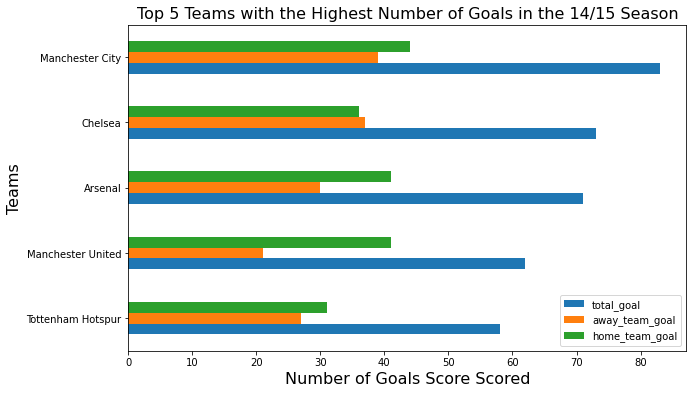

In [22]:
top_14_15 = goal_odd_14_15_sorted[["team_14_15", "total_goal", "away_team_goal","home_team_goal"]].set_index("team_14_15").tail(5)
top_14_15.plot(kind="barh", figsize=(10,6))
plt.xlabel("Number of Goals Score Scored", fontsize=16)
plt.ylabel("Teams", fontsize=16)
plt.title("Top 5 Teams with the Highest Number of Goals in the 14/15 Season", fontsize=16);

Below: Analyzing the **15/16** season goals and betting odds for the home and the away teams

In [23]:
# Total number of goals scored by home team in first season and the average odds for winning as the home match
home_15_16 = df_15_16.groupby("home_teams").agg({"home_team_goal": np.sum, "b365h":np.mean}).sort_values(by="home_team_goal", ascending=False)

In [24]:
# Total number of goals scored by away team in first season and the average odds for winning per match
away_15_16 = df_15_16.groupby("away_teams").agg({"away_team_goal": np.sum, "b365a":np.mean}).sort_values(by="away_team_goal", ascending=False)

In [25]:
goal_odd_15_16 = home_15_16.merge(away_15_16, how="outer", left_on=home_15_16.index, right_on=away_15_16.index)
goal_odd_15_16= goal_odd_15_16.rename(columns={"key_0": "team_15_16"})
goal_odd_15_16

,team_15_16,home_team_goal,b365h,away_team_goal,b365a
0,Manchester City,47,1.531053,24,1.988421
1,Southampton,39,2.102632,20,3.251579
2,Tottenham Hotspur,35,1.893158,34,2.658421
3,Everton,35,2.342632,24,3.707368
4,Leicester City,35,2.366842,33,3.471053
5,West Ham United,34,2.751579,31,5.152632
6,Liverpool,33,1.820000,30,2.800526
7,Newcastle United,32,3.444211,12,5.867368
8,Chelsea,32,1.782632,27,2.400526
9,Arsenal,31,1.545789,34,2.103684


In [26]:
goal_odd_15_16["total_goal"] = goal_odd_15_16["home_team_goal"] + goal_odd_15_16["away_team_goal"]
goal_odd_15_16_sorted= goal_odd_15_16.sort_values(by="total_goal")
goal_odd_15_16

,team_15_16,home_team_goal,b365h,away_team_goal,b365a,total_goal
0,Manchester City,47,1.531053,24,1.988421,71
1,Southampton,39,2.102632,20,3.251579,59
2,Tottenham Hotspur,35,1.893158,34,2.658421,69
3,Everton,35,2.342632,24,3.707368,59
4,Leicester City,35,2.366842,33,3.471053,68
5,West Ham United,34,2.751579,31,5.152632,65
6,Liverpool,33,1.820000,30,2.800526,63
7,Newcastle United,32,3.444211,12,5.867368,44
8,Chelsea,32,1.782632,27,2.400526,59
9,Arsenal,31,1.545789,34,2.103684,65


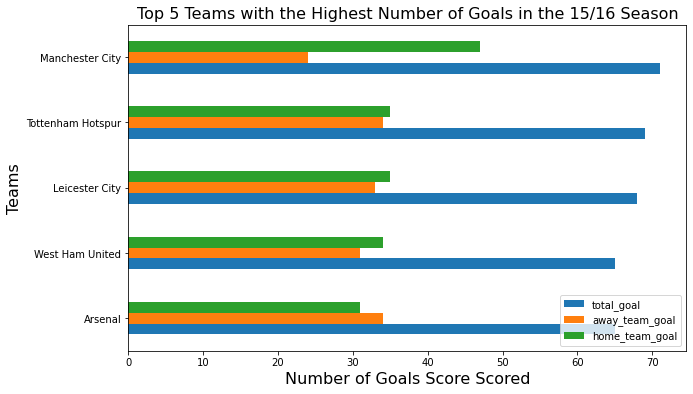

In [27]:
top_15_16 = goal_odd_15_16_sorted[["team_15_16", "total_goal", "away_team_goal","home_team_goal"]].set_index("team_15_16").tail(5)
top_15_16.plot(kind="barh", figsize=(10,6))
plt.xlabel("Number of Goals Score Scored", fontsize=16)
plt.ylabel("Teams", fontsize=16)
plt.title("Top 5 Teams with the Highest Number of Goals in the 15/16 Season", fontsize=16)
plt.legend(loc='lower right');

Comparing the total number of goals scored by each team in both seasons

In [28]:
merge_goal_odd = goal_odd_14_15.merge(goal_odd_15_16, how="outer",left_on="team_14_15", right_on="team_15_16")
Season_total = merge_goal_odd[["team_14_15", "team_15_16","total_goal_x","total_goal_y"]].fillna(0)

In [29]:
Season_total["season_goal_total"] = Season_total["total_goal_x"] + Season_total["total_goal_y"]
top_team = Season_total.sort_values(by="season_goal_total").tail(10)

In [30]:
top_team["season_goal_diff"] = top_team["total_goal_y"] - top_team["total_goal_x"]
top_team

,team_14_15,team_15_16,total_goal_x,total_goal_y,season_goal_total,season_goal_diff
9,Everton,Everton,48.0,59.0,107.0,11.0
12,West Ham United,West Ham United,44.0,65.0,109.0,21.0
2,Manchester United,Manchester United,62.0,49.0,111.0,-13.0
3,Southampton,Southampton,54.0,59.0,113.0,5.0
8,Leicester City,Leicester City,46.0,68.0,114.0,22.0
7,Liverpool,Liverpool,52.0,63.0,115.0,11.0
6,Tottenham Hotspur,Tottenham Hotspur,58.0,69.0,127.0,11.0
4,Chelsea,Chelsea,73.0,59.0,132.0,-14.0
1,Arsenal,Arsenal,71.0,65.0,136.0,-6.0
0,Manchester City,Manchester City,83.0,71.0,154.0,-12.0


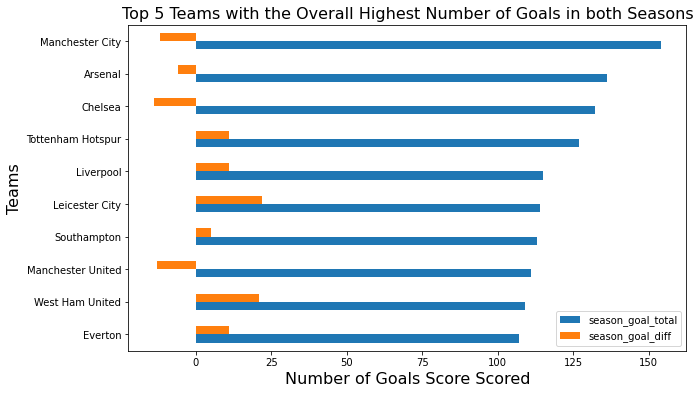

In [31]:
top_team[["team_14_15", "season_goal_total", "season_goal_diff"]].set_index("team_14_15").sort_values(by="season_goal_total").plot(kind="barh", figsize=(10,6))
plt.xlabel("Number of Goals Score Scored", fontsize=16)
plt.ylabel("Teams", fontsize=16)
plt.title("Top 5 Teams with the Overall Highest Number of Goals in both Seasons", fontsize=16);

The top three teams with the most goals across both seasons scored fewer goals in the second season than they did in the first. Only `Everton`, `Leicester City`, `Liverpool`, `Southampton`, `Tottenham Hotspur`, and `West Ham United` scored more goals in their second campaign than they did in their first.

Despite the fact that comparing the number of goals scored in each season does not reveal how much a team improved or declined, it does provide insight into each team's overall performance over the two seasons.

### Q2, Q3: Which teams were relegated from or promoted to the EPL?

In [32]:
mask=merge_goal_odd[["team_14_15", "team_15_16"]].isnull()
relegated_promoted=merge_goal_odd[mask.columns]
relegated_promoted

,team_14_15,team_15_16
0,Manchester City,Manchester City
1,Arsenal,Arsenal
2,Manchester United,Manchester United
3,Southampton,Southampton
4,Chelsea,Chelsea
5,Stoke City,Stoke City
6,Tottenham Hotspur,Tottenham Hotspur
7,Liverpool,Liverpool
8,Leicester City,Leicester City
9,Everton,Everton


Analyzing the result of the `relegated_promoted` dataframe above, we can see that certain rows indicates null. This tells whether a team was relegated at end of the 1st season or promoted at begining of the 2nd season. From the dataframe:

            * Relegated teams >> Teams present in the 14/15 season but not in the 15/16 season
            * promoted teams >> Teams present in the 15/16 season but not in the 14/15 season

      

|Relegated after 14/15|Promoted before 15/16|
|:-------------------:|:-------------------:|
|Queens Park Rangers  |Norwich City         |
|Hull City            |Bournemouth          |
|Burnley              |Watford              |

### Q4: What is the final standing/position of each team at the end of the 14/15 season?

In [33]:
df_14_15.head(1)

,stage,home_teams,home_team_goal,away_team_goal,away_teams,b365h,b356d,b365a,ht_bup_speed,at_bup_speed,...,ht_cc_crossing,at_cc_crossing,ht_cc_shooting,at_cc_shooting,ht_df_pressure,at_df_pressure,ht_df_aggression,at_df_aggression,ht_df_teamwidth,at_df_teamwidth
date,,,,,,,,,,,,,,,,,,,,,
2014-08-16,1,Arsenal,2,1,Crystal Palace,1.25,6.5,15.0,59,61,...,44,69,46,50,51,36,44,34,52,41


In [34]:
# Add Home Wins column
df_14_15["home_win"] = np.where(df_14_15["home_team_goal"] > df_14_15["away_team_goal"], 1, 0)
df_14_15.head(5)

,stage,home_teams,home_team_goal,away_team_goal,away_teams,b365h,b356d,b365a,ht_bup_speed,at_bup_speed,...,at_cc_crossing,ht_cc_shooting,at_cc_shooting,ht_df_pressure,at_df_pressure,ht_df_aggression,at_df_aggression,ht_df_teamwidth,at_df_teamwidth,home_win
date,,,,,,,,,,,,,,,,,,,,,
2014-08-16,1,Arsenal,2,1,Crystal Palace,1.25,6.50,15.0,59,61,...,69,46,50,51,36,44,34,52,41,1
2014-08-18,1,Burnley,1,3,Chelsea,9.00,5.00,1.4,54,67,...,34,47,44,63,39,62,41,58,46,0
2014-08-16,1,Leicester City,2,2,Everton,3.20,3.40,2.4,63,43,...,33,46,63,58,52,65,58,55,59,0
2014-08-17,1,Liverpool,2,1,Southampton,1.33,5.75,10.0,66,52,...,54,46,30,51,50,52,65,61,44,1
2014-08-16,1,Manchester United,1,2,Swansea City,1.36,5.00,11.0,38,45,...,36,40,55,54,31,53,47,56,42,0


In [35]:
# Add Away Wins column
df_14_15["away_win"] = np.where(df_14_15["home_team_goal"] < df_14_15["away_team_goal"], 1, 0)
df_14_15.head(1)

,stage,home_teams,home_team_goal,away_team_goal,away_teams,b365h,b356d,b365a,ht_bup_speed,at_bup_speed,...,ht_cc_shooting,at_cc_shooting,ht_df_pressure,at_df_pressure,ht_df_aggression,at_df_aggression,ht_df_teamwidth,at_df_teamwidth,home_win,away_win
date,,,,,,,,,,,,,,,,,,,,,
2014-08-16,1,Arsenal,2,1,Crystal Palace,1.25,6.5,15.0,59,61,...,46,50,51,36,44,34,52,41,1,0


In [36]:
# Add Draw column
df_14_15["draw"] = np.where(df_14_15["home_team_goal"] == df_14_15["away_team_goal"], 1, 0)
df_14_15.head(1)

,stage,home_teams,home_team_goal,away_team_goal,away_teams,b365h,b356d,b365a,ht_bup_speed,at_bup_speed,...,at_cc_shooting,ht_df_pressure,at_df_pressure,ht_df_aggression,at_df_aggression,ht_df_teamwidth,at_df_teamwidth,home_win,away_win,draw
date,,,,,,,,,,,,,,,,,,,,,
2014-08-16,1,Arsenal,2,1,Crystal Palace,1.25,6.5,15.0,59,61,...,50,51,36,44,34,52,41,1,0,0


In [37]:
# Points from wining or drawing a match while playing at home
result1 =df_14_15.groupby("home_teams")[["home_win","draw","away_win"]].sum()
result1["home_points"] = ((result1["home_win"])*3)  +  ((result1["draw"])*1)
result1

,home_win,draw,away_win,home_points
home_teams,,,,
Arsenal,12,5,2,41
Aston Villa,5,6,8,21
Burnley,4,7,8,19
Chelsea,15,4,0,49
Crystal Palace,6,3,10,21
Everton,7,7,5,28
Hull City,5,5,9,20
Leicester City,7,5,7,26
Liverpool,10,5,4,35


In [38]:
# Points from wining or drawing a match while playing away
result2 =df_14_15.groupby("away_teams")[["home_win","draw","away_win"]].sum()
result2["away_points"] = ((result2["away_win"])*3)  +  ((result2["draw"])*1)
result2

,home_win,draw,away_win,away_points
away_teams,,,,
Arsenal,5,4,10,34
Aston Villa,12,2,5,17
Burnley,11,5,3,14
Chelsea,3,5,11,38
Crystal Palace,6,6,7,27
Everton,10,4,5,19
Hull City,10,6,3,15
Leicester City,12,3,4,15
Liverpool,8,3,8,27


In [39]:
final_result = result1.merge(result2, left_index=True, right_index=True, how="inner")[["home_points", "away_points"]]
final_result["total_points"] = (final_result["home_points"]+ final_result["away_points"])
final_result = final_result.sort_values(by="total_points", ascending=False)

final_result

,home_points,away_points,total_points
home_teams,,,
Chelsea,49,38,87
Manchester City,45,34,79
Arsenal,41,34,75
Manchester United,44,26,70
Tottenham Hotspur,33,31,64
Liverpool,35,27,62
Southampton,37,23,60
Swansea City,32,24,56
Stoke City,33,21,54


The table above shows the final standing and position of each team (determined by the `total_points` column) at the end of the 2014/2015 EPL season. 

`Chelsea`, with the most points, was crowned the EPL 14/15 season's champion.

The top four teams (`Chelsea`,`Manchester City`,`Arsenal`,`Manchester United`) all qualified to play in the following year's (2015/2016) champions league competition.

The bottom three teams (`Hull City`, `Burnley`, `Queens Park Rangers`) all relegated to the lower division.

### Q5: Which team attributes are most likely responsible for  home/away matches won?

In [40]:
ht_attributes = ["home_win"]
at_attributes = ["away_win"]
for c in df_14_15.columns:
    if "ht_" in c:
        ht_attributes.append(c)
    elif "at_" in c:
        at_attributes.append(c)
print(ht_attributes)
print(at_attributes)

['home_win', 'ht_bup_speed', 'ht_bup_dribbling', 'ht_bup_passing', 'ht_cc_passing', 'ht_cc_crossing', 'ht_cc_shooting', 'ht_df_pressure', 'ht_df_aggression', 'ht_df_teamwidth']
['away_win', 'at_bup_speed', 'at_bup_dribbling', 'at_bup_passing', 'at_cc_passing', 'at_cc_crossing', 'at_cc_shooting', 'at_df_pressure', 'at_df_aggression', 'at_df_teamwidth']


In [41]:
home_att = df_14_15.groupby("home_teams")[ht_attributes].mean()
away_att = df_14_15.groupby("away_teams")[at_attributes].mean()

In [42]:
home_corr = df_14_15[ht_attributes].corr()
home_corr

,home_win,ht_bup_speed,ht_bup_dribbling,ht_bup_passing,ht_cc_passing,ht_cc_crossing,ht_cc_shooting,ht_df_pressure,ht_df_aggression,ht_df_teamwidth
home_win,1.000000,0.038123,0.050038,-0.261993,-0.213510,-0.148710,-0.159433,0.022318,0.018077,-0.002153
ht_bup_speed,0.038123,1.000000,0.006946,0.032155,0.127831,0.252056,-0.487907,-0.377159,-0.231800,-0.266107
ht_bup_dribbling,0.050038,0.006946,1.000000,-0.289829,-0.494193,-0.353942,0.289986,0.084960,-0.099640,0.288074
ht_bup_passing,-0.261993,0.032155,-0.289829,1.000000,0.840246,0.762792,0.162375,-0.075409,-0.052692,-0.151947
ht_cc_passing,-0.213510,0.127831,-0.494193,0.840246,1.000000,0.734601,-0.048728,-0.184324,-0.233864,-0.233403
ht_cc_crossing,-0.148710,0.252056,-0.353942,0.762792,0.734601,1.000000,-0.188113,-0.171531,-0.192653,-0.408993
ht_cc_shooting,-0.159433,-0.487907,0.289986,0.162375,-0.048728,-0.188113,1.000000,0.174638,-0.070781,0.176950
ht_df_pressure,0.022318,-0.377159,0.084960,-0.075409,-0.184324,-0.171531,0.174638,1.000000,0.743174,0.746814
ht_df_aggression,0.018077,-0.231800,-0.099640,-0.052692,-0.233864,-0.192653,-0.070781,0.743174,1.000000,0.508679
ht_df_teamwidth,-0.002153,-0.266107,0.288074,-0.151947,-0.233403,-0.408993,0.176950,0.746814,0.508679,1.000000


In [43]:
away_corr = df_14_15[at_attributes].corr()
away_corr

,away_win,at_bup_speed,at_bup_dribbling,at_bup_passing,at_cc_passing,at_cc_crossing,at_cc_shooting,at_df_pressure,at_df_aggression,at_df_teamwidth
away_win,1.000000,0.063858,0.101655,-0.228562,-0.201062,-0.172850,-0.078268,0.026430,0.019740,0.002672
at_bup_speed,0.063858,1.000000,0.006946,0.032155,0.127831,0.252056,-0.487907,-0.377159,-0.231800,-0.266107
at_bup_dribbling,0.101655,0.006946,1.000000,-0.289829,-0.494193,-0.353942,0.289986,0.084960,-0.099640,0.288074
at_bup_passing,-0.228562,0.032155,-0.289829,1.000000,0.840246,0.762792,0.162375,-0.075409,-0.052692,-0.151947
at_cc_passing,-0.201062,0.127831,-0.494193,0.840246,1.000000,0.734601,-0.048728,-0.184324,-0.233864,-0.233403
at_cc_crossing,-0.172850,0.252056,-0.353942,0.762792,0.734601,1.000000,-0.188113,-0.171531,-0.192653,-0.408993
at_cc_shooting,-0.078268,-0.487907,0.289986,0.162375,-0.048728,-0.188113,1.000000,0.174638,-0.070781,0.176950
at_df_pressure,0.026430,-0.377159,0.084960,-0.075409,-0.184324,-0.171531,0.174638,1.000000,0.743174,0.746814
at_df_aggression,0.019740,-0.231800,-0.099640,-0.052692,-0.233864,-0.192653,-0.070781,0.743174,1.000000,0.508679
at_df_teamwidth,0.002672,-0.266107,0.288074,-0.151947,-0.233403,-0.408993,0.176950,0.746814,0.508679,1.000000


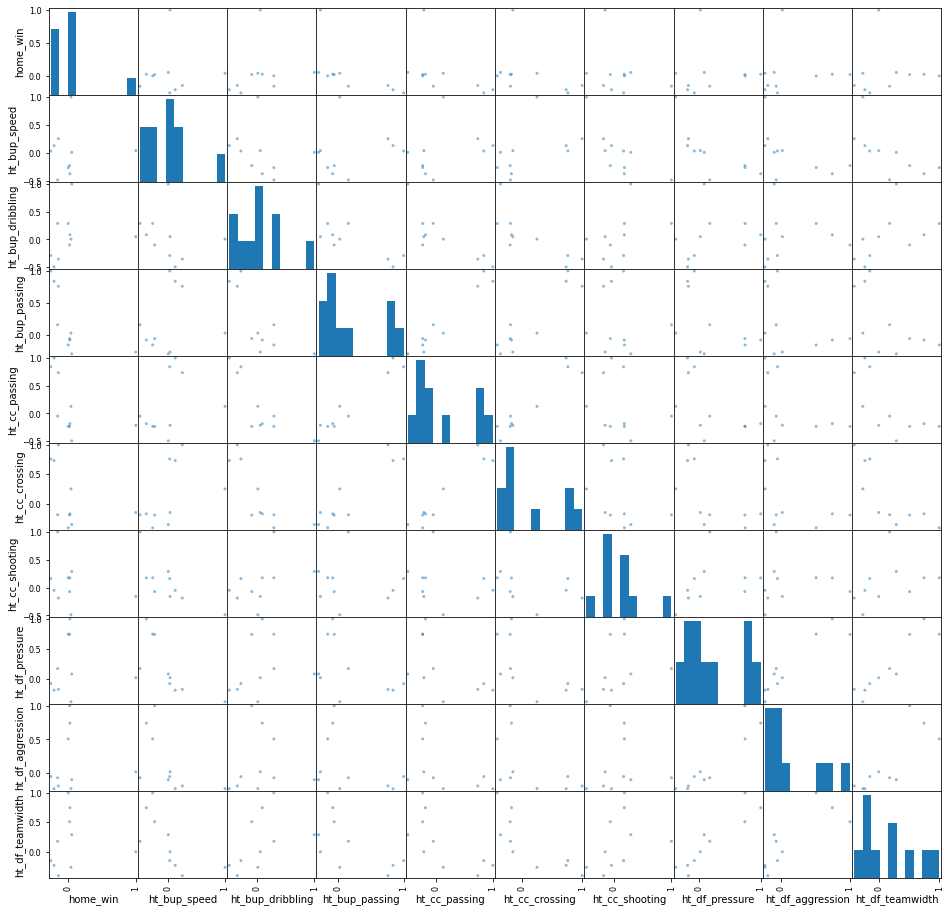

In [44]:
pd.plotting.scatter_matrix(home_corr, figsize=(16,16));

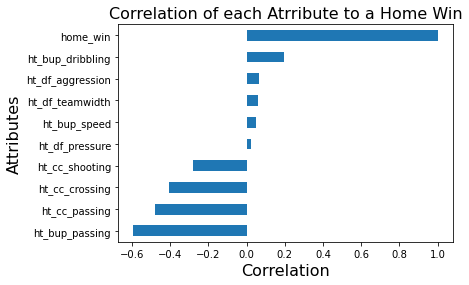

In [45]:
home_corr.corr()["home_win"].sort_values().plot(kind="barh")
plt.xlabel("Correlation", fontsize=16)
plt.ylabel("Attributes", fontsize=16)
plt.title("Correlation of each Atrribute to a Home Win", fontsize=16);

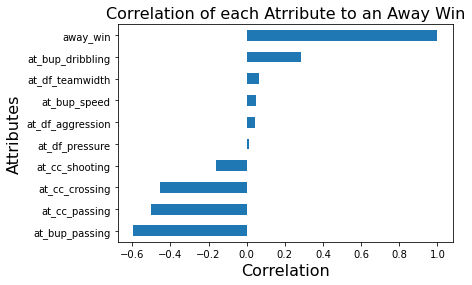

In [46]:
away_corr.corr()["away_win"].sort_values().plot(kind="barh")
plt.xlabel("Correlation", fontsize=16)
plt.ylabel("Attributes", fontsize=16)
plt.title("Correlation of each Atrribute to an Away Win", fontsize=16);

> From the tables above and their corresponding barplots, it is seen that there is a weak correlation between the team attributes and the the chances of a team winning a match either at home or away. The strongest positive correlation is seen with the **Build-up-Play dribbling**. For some unknown reasons, all the **Chance Creation (cc)** attributes and the **Build-up-Play Passing** (strongest negative correlation for home or away win) show a negative correlation with a team winning a match at home or away. Even though correlations are weak, there might be some reasons for these. Unfortunately, there are not enough data to explore this.

<a id='conclusions'></a>
## Conclusions

The exploration of the soccer database has reveled some insights into the data. It is, however, difficult to make decisions based on these insides for a number of reason. One being that the data is from a long period and as such, data might be of little relevance, especially if it's intented to help make some form of predictions. Other limitations exist in that, data such as the team attributes might be inconsitent or even misleading to a large extent; hence, analysis or decision made on these attributes are not to be trusted.

As seen in the analysis of 1st question, comparing the total number of goals scored by each team in the two seasons considered does not help us determine where a team had improved (compared to the previous year) or not. More or less goals does not necessarily translate to an improvement or a decline.

Nevertheless, reasonable and proven conclusions can be drawn from the analysis of the 2nd, 3rd, and 4th questions. It was clearly reveled which teams relegated, got promoted, won the league, etc. from the EDA conducted.

More work can be done to improve the analysis and draw out more conclusions from the data especially around the relationship between the match betting odds and the probablity of winning a bet.


In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'ALX-Udacity Project 1— Investigating a Soccer Dataset.ipynb'])

1